# 1) Data Exploration

## 1.0) Imports

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np

import os
import random

import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
from IPython.display import display, Image as IPImage
import shutil

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import models, layers
from tensorflow.keras import optimizers, callbacks
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

## 1.1) Load Data

Pré-requis : 
- Avoir le fichier pokemon.csv ("raw_data/computer_vision/pokemon.csv")
- Avoir les images de kaggle ("raw_data/computer_vision/images/")
- Avoir les images supplémentaires scrapées ("raw_data/computer_vision/pokemon/")

In [2]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
csv_path = os.path.join(parent_directory, "raw_data/computer_vision/pokemon.csv")

df = pd.read_csv(csv_path)

In [3]:
images_directory = os.path.join(parent_directory, "raw_data/computer_vision/images/")

In [4]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


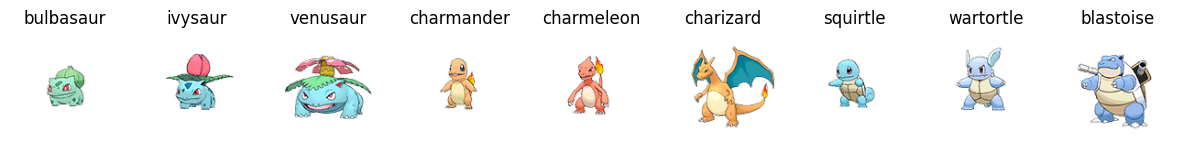

In [5]:
fig, axes = plt.subplots(1, 9, figsize=(15, 5))

for i, nom_pokemon in enumerate(df['Name'].head(9)):
    chemin_image_png = images_directory + nom_pokemon.lower() + ".png"
    chemin_image_jpg = images_directory + nom_pokemon.lower() + ".jpg"

    if os.path.exists(chemin_image_png):
        chemin_image = chemin_image_png
    elif os.path.exists(chemin_image_jpg):
        chemin_image = chemin_image_jpg
    else:
        print(f"Aucun fichier trouvé pour {nom_pokemon}")
        continue

    img = Image.open(chemin_image)

    axes[i].imshow(img)
    axes[i].set_title(nom_pokemon)
    axes[i].axis('off')

plt.show()


## 1.2) Clean Data

Remarque : Cette partie n'est pas à faire tourner si vous partez des fichiers "clean" mis sur le drive, càd les dossiers train/test comportant les 18 types de pokémon chacun avec l'ensemble des images (incluant celles de Kaggle + celles scrapées)

Nous laisserons tout de même cette partie afin de documenter le travail effectué pour atteindre notre classification finale

### 1.2.1) Preprocessing: OHE

In [6]:
df.head()

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [7]:
df = df.copy()
df = df.fillna('')

# Use column transformer to preprocess type1 and type2
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse=False, drop='first'), ['Type1', 'Type2'])
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Apply the ohe
df_ohe = pipeline.fit_transform(df[['Type1', 'Type2']])
feature_names_out = pipeline.named_steps['preprocessor'].named_transformers_['onehot'].get_feature_names_out(['Type1', 'Type2'])
onehot_df = pd.DataFrame(df_ohe, columns=feature_names_out)

# Delete the prefixe Type_1 and Type_2 for every columns
for col in onehot_df.columns:
    if col.startswith('Type1_'):
        onehot_df.rename(columns={col: col.replace('Type1_', '')}, inplace=True)
    elif col.startswith('Type2_'):
        onehot_df.rename(columns={col: col.replace('Type2_', '')}, inplace=True)

merged_df = onehot_df.groupby(level=0, axis=1).sum()
df_ohe = pd.concat([df, merged_df], axis=1)
df_ohe = df_ohe.drop(['Type1', 'Type2'], axis=1)
df = df_ohe

/home/morgane/.pyenv/versions/3.10.6/envs/catchemall/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
df

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,charmander,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
804,stakataka,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
805,blacephalon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
806,zeraora,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
807,meltan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 1.2.2) Sorting: Création de dossiers par type de Pokémon

Le code ci-dessous est à faire tourner lorsque vous avez un dossier raw_data/computer_vision/images/ avec les 809 images initiales de Kaggle, afin de trier toutes ces images dans des nouveaux dossiers classés par type de pokémon

In [9]:
# types = set(df['Type1'])
# types_directory = os.path.join(parent_directory, "raw_data/computer_vision/types/")
# for pokemon_type in types:
#     type_directory_path = os.path.join(types_directory, pokemon_type)
#     # Pour vérifier si dossier existe déjà, sinon créer
#     if not os.path.exists(type_directory_path):
#         os.makedirs(type_directory_path)
# for index, row in df.iterrows():
#     pokemon_name = row['Name']
#     type1 = row['Type1']
#     type2 = str(row['Type2'])  # str pcq sinon ça bug à cause des NaN

#     type1_directory_path = os.path.join(types_directory, type1)
#     if os.path.exists(type1_directory_path):
#         for ext in ['jpg', 'png']:
#             source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#             if os.path.exists(source_image_path):
#                 destination_path = os.path.join(type1_directory_path, f'{pokemon_name}.{ext}')
#                 shutil.copy(source_image_path, destination_path)
#                 break

#     # Vérifier si le type 2 existe et copier l'image
#     if type2:
#         type2_directory_path = os.path.join(types_directory, type2)
#         if os.path.exists(type2_directory_path):
#             for ext in ['jpg', 'png']:
#                 source_image_path = os.path.join(images_directory, f'{pokemon_name}.{ext}')
#                 if os.path.exists(source_image_path):
#                     destination_path = os.path.join(type2_directory_path, f'{pokemon_name}.{ext}')
#                     shutil.copy(source_image_path, destination_path)
#                     break

### 1.2.3) Cleaning fichiers .Identifier

In [10]:
def cleaning_identifier(folder):
    for filename in os.listdir(folder):
        if filename.endswith('.Identifier'):
            target_to_remove = os.path.join(folder, filename)
            os.remove(target_to_remove)

# cleaning_identifier (mettre dossier à clean)

In [11]:
def auto_cleaning_identifier(folder):
    for filename in os.listdir(folder):
        tiny_folder = os.path.join(folder, filename)
        print(tiny_folder)
        if os.path.isdir(tiny_folder):
            for tiny_filename in os.listdir(tiny_folder):
                if tiny_filename.endswith('.Identifier'):
                    target_to_remove = os.path.join(tiny_folder, tiny_filename)
                    os.remove(target_to_remove)
        print(os.path.isdir(tiny_folder))
        if filename.endswith('.Identifier'):
            target_to_remove = os.path.join(folder, filename)
            os.remove(target_to_remove)

# auto_cleaning_identifier (mettre dossier types à clean)

### 1.2.4) Ajout des fichiers images supplémentaires dans les dossiers types

À cette étape, nous avons rajouté les 42,000 images scrapées afin d'avoir une base image plus complète.
Nous avons mis toutes ces images dans un dossier nommé "pokemon" (source_folder = catchemall\raw_data\computer_vision\pokemon), et ces images ont été copiées, grâce à la fonction ci-dessous, dans chaque dossier correspondant au type du pokémon (target_folder = catchemall\raw_data\computer_vision\types)

In [12]:
path_images = os.path.join(parent_directory, "raw_data/computer_vision/types/")
source_image = os.path.join(parent_directory, "raw_data/computer_vision/pokemon/")

In [13]:
def copy_matching_pokemon_images(source_folder, target_folder):
    # check every type of pokemon
    for type_folder in os.listdir(target_folder):
        type_folder_path = os.path.join(target_folder, type_folder)

        # check file type in lower
        for target_name in os.listdir(type_folder_path):
            target_name_brut = target_name.lower()
            target_parts = target_name_brut.split('.')
            target_name = target_parts[0]

            # look every image on the new data source
            for filename in os.listdir(source_folder):
                source_file_path = os.path.join(source_folder, filename)

                # check source in lower
                source_filename_lower = filename.lower()
                
                # if the file start with de correct name
                if source_filename_lower.startswith(target_name):
                    # create the target
                    target_file_path = os.path.join(type_folder_path, filename)
                    # copy the image
                    shutil.copy(source_file_path, target_file_path)

source_folder = source_image
target_folder = path_images

# copy_matching_pokemon_images(source_folder, target_folder)

### 1.2.5) Redimensionnement des nouvelles images

Les nouvelles images scrapées ont des formats différents du format voulu (cf ci-dessous). Nous allons donc les redimensionner.

In [14]:
img1 = load_img(f"{path_images}/Fire/moltres.png")
x1 = img_to_array(img)

img2 = load_img(f"{path_images}/Fire/Magmar_9657.png")
x2 = img_to_array(img)

print(x1.shape)
print(x2.shape)

(120, 120, 4)
(120, 120, 4)


Cependant, avant de redimensionner les nouvelles images, nous allons faire le train/test/split car nous voulons redimensionner uniquement les images du train set.

In [15]:
types_pokemon = df.columns
types_pokemon = types_pokemon.drop('Name')
types_pokemon

Index(['Bug', 'Dark', 'Dragon', 'Electric', 'Fairy', 'Fighting', 'Fire',
       'Flying', 'Ghost', 'Grass', 'Ground', 'Ice', 'Normal', 'Poison',
       'Psychic', 'Rock', 'Steel', 'Water'],
      dtype='object')

In [16]:
# Création d'un dictionnaire pour ranger toutes les images pokémon en fonction de leur type
pokemon_dict = {}
for type_pokemon in types_pokemon:
    path_images_type = f"{path_images}{type_pokemon}"
    pokemon_dict[type_pokemon] = ""
    temp_list = []
    for fichier in os.listdir(path_images_type):
        if fichier.endswith(('.png', '.jpg', 'jpeg')):
            temp_list.append(fichier)
            pokemon_dict[type_pokemon]=temp_list

In [17]:
my_picture_path = {}
count = 0
for key, values in pokemon_dict.items():
    temp_list = []
    for i in values:
        chemin_image = f"{path_images}{key}/{i}"
        temp_list.append(chemin_image)
        my_picture_path[key] = temp_list
        count += 1

In [18]:
pourcentage_train = 80

root_folder = os.path.join(parent_directory, "raw_data/computer_vision/")
destination_folder = os.path.join(root_folder, "train_test")
destination_train = os.path.join(destination_folder, "train")
destination_test = os.path.join(destination_folder, "test")

# clear the destination folder if exist
def clear_folder(folder):
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder)

# apply the cleaning function
clear_folder(destination_folder)

for type_pokemon, fichiers in my_picture_path.items():
    # shuffle the path
    random.shuffle(fichiers)

    # take the pourcentage of train and round on integer
    split_index = int(len(fichiers) * pourcentage_train / 100)

    # manual slip for train/test
    train_set = fichiers[:split_index]
    test_set = fichiers[split_index:]

    # create train/test folder for every type
    train_folder = f"{type_pokemon}_train"
    test_folder = f"{type_pokemon}_test"
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # create a !!COPY!! for every pic on the right folder
    for fichier in train_set:
        shutil.copy(fichier, os.path.join(train_folder, os.path.basename(fichier)))

    for fichier in test_set:
        shutil.copy(fichier, os.path.join(test_folder, os.path.basename(fichier)))

    # move all folder on the right place
    shutil.move(train_folder, os.path.join(destination_train, train_folder))
    shutil.move(test_folder, os.path.join(destination_test, test_folder))


Une fois le split effectué, nous pouvons traiter nos images.
Le code suivant crée un sous-dossier "resized" dans chaque dossier, ce qui permet de vérifier si le resizing s'effectue correctement. Cependant, pour plus de facilité d'accès à ces images resized, nous allons plutôt utiliser le code non-commenté qui place les images redimensionnées directement dans le dossier Type

In [19]:
# target_size = (120, 120)

# def resize_image(image_path):
#     img = Image.open(image_path)
#     img_resized = img.resize(target_size, Image.LANCZOS)

#     # Forcer le mode de l'image à rester en RGB sinon kk
#     img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

#     img.close()
#     return img_array

# def resize_images_in_directory(directory):
#     # Parcourir les sous-dossiers
#     for poketype_folder in os.listdir(directory):
#         poketype_folder_path = os.path.join(directory, poketype_folder)

#         if os.path.isdir(poketype_folder_path):
#             # pour suivre que ya rien qui crash
#             print(f"Redimensionnement des images dans le dossier {poketype_folder}...")

#             # Créer un sous-dossier 'resized' pour sauvegarder les images redimensionnées
#             resized_folder_path = os.path.join(poketype_folder_path, 'resized')
#             os.makedirs(resized_folder_path, exist_ok=True)

#             # Parcourir les images dans le dossier de chaque type
#             image_files = [f for f in os.listdir(poketype_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

#             for image_file in image_files:
#                 image_path = os.path.join(poketype_folder_path, image_file)

#                 try:
#                     resized_image_array = resize_image(image_path)

#                     rescale_layer = Rescaling(scale=1./255)
#                     resized_image_array = rescale_layer(np.expand_dims(resized_image_array, axis=0))[0]

#                     save_path = os.path.join(resized_folder_path, image_file)
#                     array_to_img(resized_image_array).save(save_path)
#                 except ValueError as e:
#                     print(f"Ignoré l'image {image_file} dans le dossier {poketype_folder} : {e}") # ignorer sinon crash
#                     continue

In [20]:
train_data_dir = parent_directory + "/raw_data/computer_vision/train_test/train/"
test_data_dir = parent_directory + "/raw_data/computer_vision/train_test/test/"
print(train_data_dir)
print(test_data_dir)

/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/train/
/home/morgane/code/mtthibault/catchemall/raw_data/computer_vision/train_test/test/


In [21]:
target_size = (120, 120)

def resize_image(image_path):
    img = Image.open(image_path)
    img_resized = img.resize(target_size, Image.LANCZOS)

    # Forcer le mode de l'image à rester en RGB sinon kk
    img_array = img_to_array(img_resized, data_format="channels_last", dtype="uint8")

    img.close()
    return img_array

def resize_images_in_directory(directory):
    # Parcourir les sous-dossiers
    for poketype_folder in os.listdir(directory):
        poketype_folder_path = os.path.join(directory, poketype_folder)

        if os.path.isdir(poketype_folder_path):
            # pour suivre que ya rien qui crash
            print(f"Redimensionnement des images dans le dossier {poketype_folder}...")

            # Parcourir les images dans le dossier de chaque type
            image_files = [f for f in os.listdir(poketype_folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

            for image_file in image_files:
                image_path = os.path.join(poketype_folder_path, image_file)

                try:
                    resized_image_array = resize_image(image_path)

                    rescale_layer = Rescaling(scale=1./255)
                    resized_image_array = rescale_layer(np.expand_dims(resized_image_array, axis=0))[0]

                    # Utiliser le même dossier que l'original pour sauvegarder les images redimensionnées
                    save_path = os.path.join(poketype_folder_path, image_file)
                    array_to_img(resized_image_array).save(save_path)
                except ValueError as e:
                    print(f"Ignoré l'image {image_file} dans le dossier {poketype_folder} : {e}") # ignorer sinn crash
                    continue


## 1.3)  Visualize Data

In [22]:
df.head()

,Name,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
0,bulbasaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,ivysaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,venusaur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,charmander,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,charmeleon,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Calcul nombre d'images pokemon par type
pokemon_nb = []
for key, values in pokemon_dict.items():
    taille = len(pokemon_dict[key])
    pokemon_nb.append(taille)

# Dictionnaire affichant le nombre d'images par type
pokemon_nb_per_type = {}
for key, values in pokemon_dict.items():
    pokemon_nb_per_type[key] = len(pokemon_dict[key])

pokemon_nb_per_type

{'Bug': 3318,
 'Dark': 1831,
 'Dragon': 1544,
 'Electric': 2170,
 'Fairy': 1561,
 'Fighting': 2068,
 'Fire': 2726,
 'Flying': 4557,
 'Ghost': 1376,
 'Grass': 3903,
 'Ground': 3245,
 'Ice': 1620,
 'Normal': 5018,
 'Poison': 3572,
 'Psychic': 3556,
 'Rock': 2738,
 'Steel': 1809,
 'Water': 6523}

Type: Bug


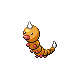

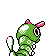

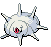



Type: Dark


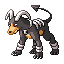

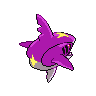

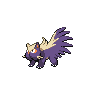



Type: Dragon


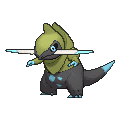

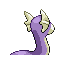

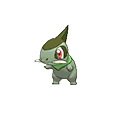



Type: Electric


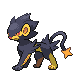

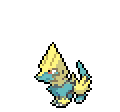

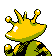



Type: Fairy


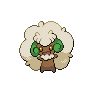

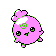

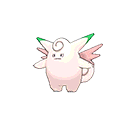



Type: Fighting


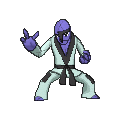

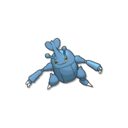

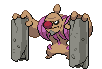



Type: Fire


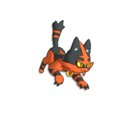

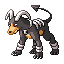

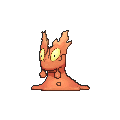



Type: Flying


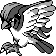

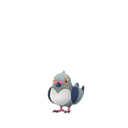

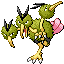



Type: Ghost


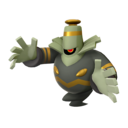

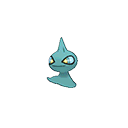

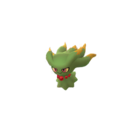



Type: Grass


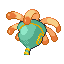

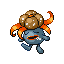

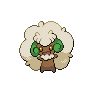



Type: Ground


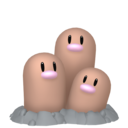

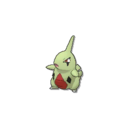

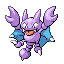



Type: Ice


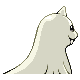

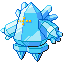

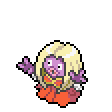



Type: Normal


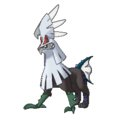

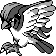

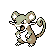



Type: Poison


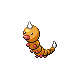

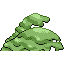

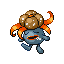



Type: Psychic


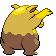

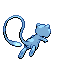

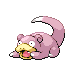



Type: Rock


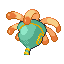

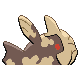

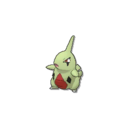



Type: Steel


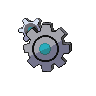

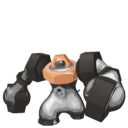

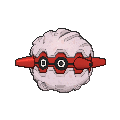



Type: Water


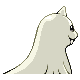

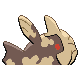

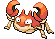

In [24]:
num_images_to_display = 3

for pokemon_type, pokemon_names in pokemon_dict.items():
    print(f"Type: {pokemon_type}")
    
    for name in pokemon_names[:num_images_to_display]:
        image_path = os.path.join(path_images, pokemon_type, f"{name}")
        display(IPImage(filename=image_path))
    
    print("\n")

# 2) Train/Test Split

In [25]:
train_ds = image_dataset_from_directory(train_data_dir,
                                        labels="inferred",
                                        label_mode="categorical",
                                        image_size=(120,120),
                                        batch_size=32,
                                        seed=123)

train_ds

Found 42500 files belonging to 18 classes.


2023-12-08 14:39:55.713457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 14:39:55.713700: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

In [26]:
val_ds = image_dataset_from_directory(test_data_dir,
                                      labels="inferred",
                                      label_mode="categorical",
                                      image_size=(120,120),
                                      batch_size=32,
                                      seed=123)

val_ds

Found 10635 files belonging to 18 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 18), dtype=tf.float32, name=None))>

# 3) Models

## 4.1) Fonctions plotting

In [27]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    # LOSS
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[0].legend()
    ax[0].grid()
    
    # ACCURACY
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[1].legend()
    ax[1].grid()

In [28]:
def plot_loss_accuracy(history):

    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    ## Plot Losses and Accuracies
    x_axis = np.arange(len(history.history['loss']))

    ax[0].set_title("Loss")
    ax[0].plot(x_axis, history.history['loss'], color="blue", linestyle=":", marker="X", label="Train Loss")
    ax[0].plot(x_axis, history.history['val_loss'], color="orange", linestyle="-", marker="X", label="Val Loss")

    ax[1].set_title("Accuracy")
    ax[1].plot(x_axis, history.history['accuracy'], color="blue", linestyle=":", marker="X", label="Train Accuracy")
    ax[1].plot(x_axis,
               history.history['val_accuracy'],
               color="orange",
               linestyle="-",
               marker="X",
               label="Val Accuracy")

    ## Customization
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)
    ax[0].legend()

    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)
    ax[1].legend()


    plt.show()

## 4.2) Initialisation du modèle

In [34]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.RandomFlip("horizontal"))
data_augmentation.add(layers.RandomZoom((0.1, 0.2)))
data_augmentation.add(layers.RandomTranslation(0.2, 0.2))
data_augmentation.add(layers.RandomRotation(0.1))

vgg16 = VGG16(weights = "imagenet", 
              include_top = False,
              input_shape = (120, 120, 3))

vgg16.trainable = False

my_dense_layers = models.Sequential()

my_dense_layers.add(layers.Dense(64, activation="relu"))
my_dense_layers.add(layers.Dropout(rate=0.5))         

predictive_layer = layers.Dense(18, activation="softmax")

In [35]:
def initialize_model():
    inputs = layers.Input(shape = (120, 120, 3))
    x = data_augmentation(inputs)
    x = preprocess_input(x)
    x = vgg16(x)
    
    x = layers.Flatten()(x)
    
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.BatchNormalization()(x)
    
    pred = layers.Dense(18, activation="softmax")(x)
    
    model = models.Model(inputs=inputs, outputs=pred)
    
    return model

In [36]:
model = initialize_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 120, 120, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 120, 120, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0     

In [39]:
def compile_model(model, optimizer_name):
    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer_name,
        metrics = ['accuracy']
    )
    return model

In [40]:
model = compile_model(model, 'adam')

In [41]:
lr_scheduler = callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.95 ** epoch)
early_stopper = callbacks.EarlyStopping(
    patience=10,
    monitor="val_loss",
    restore_best_weights=True
)

## 4.3) Fitting du modèle

In [42]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[early_stopper, lr_scheduler]
)

1329/1329 [==============================] - 546s 410ms/step - loss: 2.8783 - accuracy: 0.1246 - val_loss: 2.5520 - val_accuracy: 0.2041 - lr: 0.0010


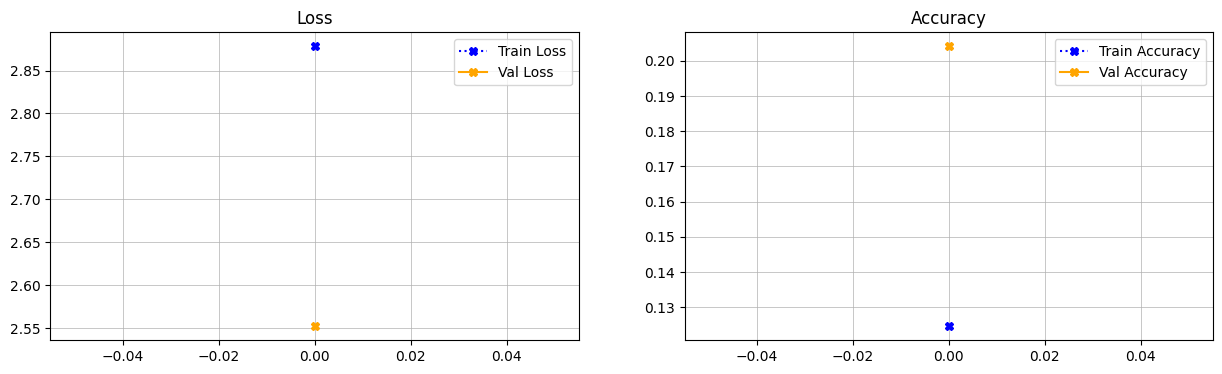

In [44]:
plot_loss_accuracy(history)

## 4.4) Save and load a fitted model

In [45]:
models.save_model(model, 'my_first_model')

INFO:tensorflow:Assets written to: my_first_model/assets


INFO:tensorflow:Assets written to: my_first_model/assets


In [46]:
!ls

ben_computer_vision_first_model.ipynb  computervision_packaging.ipynb
catchemall-project-caspar.ipynb        mo_computervision_models.ipynb
computer_vision_first_model.ipynb      my_first_model
computer_vision_ohe.ipynb	       toto_test_synchronisation.ipynb


In [47]:
loaded_model = models.load_model('my_first_model')
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 120, 120, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 120, 120, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0     

# Prédiction